# Imports and Data

In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [2]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: C:\Users\majerm\projects\local\rug-sna-pizza-giving\college_msg_files\dataset\CollegeMsg.txt
done


In [5]:
def export_graph(
        graph: nx.DiGraph,
        pos: dict,
        export_path: Path = None,
        fig_size=(20, 20),
        base_node_size=0,
        node_size_factor=10,
        edge_alpha=0.2,
        node_color_map='viridis',
        default_node_color='lightgray',
        edge_color='gray',
        dpi=300,
        xlim=None,
        ylim=None
):
    """
    Exports a NetworkX graph to an image file with consistent styling and a colormap based on node message counts.

    Parameters:
    - graph (nx.DiGraph): The directed graph to export.
    - pos (dict): A dictionary specifying node positions.
    - export_path (Path, optional): Path to save the exported image. If None, the image is not saved.
    - fig_size (tuple, optional): Size of the figure in inches. Defaults to (10, 10).
    - base_node_size (int, optional): Base size for nodes. Defaults to 100.
    - node_size_factor (int, optional): Factor to scale node sizes based on degree. Defaults to 20.
    - edge_alpha (float, optional): Transparency level for edges (0 to 1). Defaults to 0.3.
    - node_color_map (str, optional): Matplotlib colormap name for node colors. Defaults to 'viridis'.
    - default_node_color (str, optional): Color for nodes with zero messages. Defaults to 'lightgray'.
    - edge_color (str or list, optional): Color of the edges. Defaults to 'gray'.
    - dpi (int, optional): Dots per inch for the saved image. Defaults to 300.
    - xlim (tuple, optional): Limits for the x-axis.
    - ylim (tuple, optional): Limits for the y-axis.
    """

    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate the total degree (in-degree + out-degree) for each node
    degrees = {node: graph.in_degree(node) + graph.out_degree(node) for node in graph.nodes()}

    # Scale node sizes based on their degrees
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in graph.nodes()]

    # Prepare color mapping based on degrees
    non_zero_degrees = [deg for deg in degrees.values() if deg > 0]

    if non_zero_degrees:
        norm = Normalize(vmin=min(non_zero_degrees), vmax=max(non_zero_degrees))
        cmap = plt.colormaps.get_cmap(node_color_map)
        node_colors = [
            cmap(norm(degrees[node])) if degrees[node] > 0 else default_node_color
            for node in graph.nodes()
        ]
    else:
        node_colors = [default_node_color for _ in graph.nodes()]

    # Draw edges with specified transparency
    nx.draw_networkx_edges(
        graph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        arrows=True,
        arrowstyle='->',
        arrowsize=10,
        connectionstyle='arc3,rad=0.1'
    )

    # Draw nodes with scaled sizes and color mapping
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        linewidths=0.5
    )

    # Set consistent axis limits
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(export_path, bbox_inches='tight', dpi=dpi, pad_inches=0.1)

    # Close the figure to free up memory
    plt.close()

# Important Nodes

Calculating layout ...


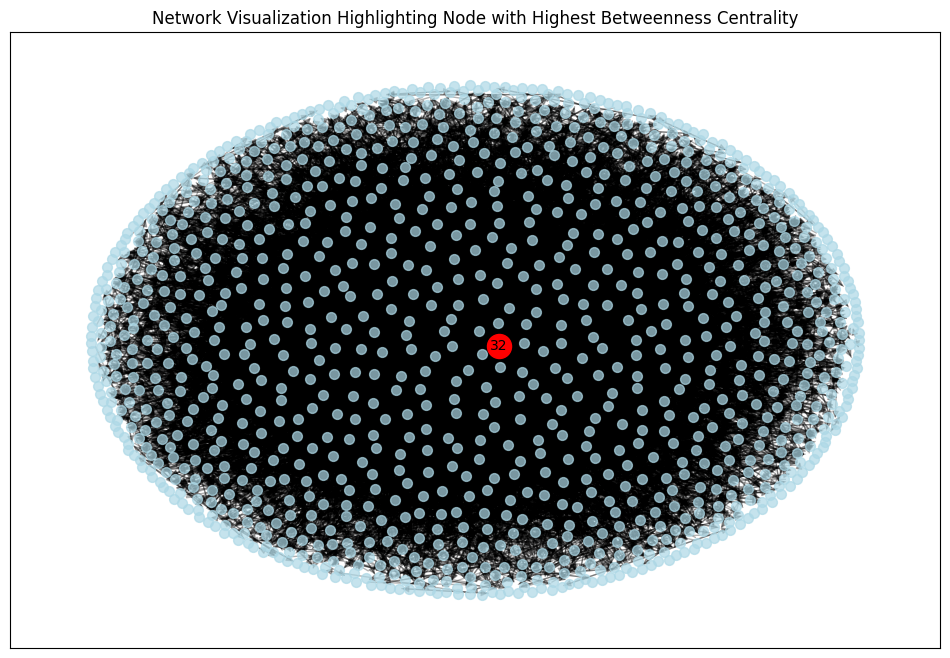

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming DF_MESSAGES is already imported and GRAPH_MESSAGES is your directed graph

# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(GRAPH_MESSAGES)

# Find the node with the highest betweenness centrality
max_betweenness_node = max(betweenness, key=betweenness.get)

# Draw the graph focusing on the highest betweenness centrality node
plt.figure(figsize=(12, 8))

# Layout for positioning the nodes
pos = cache_layout(GRAPH_MESSAGES, nx.arf_layout)

# Draw all nodes with default color
nx.draw_networkx_nodes(GRAPH_MESSAGES, pos, node_color='lightblue', node_size=50, alpha=0.7)

# Highlight the node with the highest betweenness centrality
nx.draw_networkx_nodes(GRAPH_MESSAGES, pos, nodelist=[max_betweenness_node], node_color='red', node_size=300, alpha=1.0)

# Draw edges
nx.draw_networkx_edges(GRAPH_MESSAGES, pos, alpha=0.3)

# Draw labels for better understanding (optional)
nx.draw_networkx_labels(GRAPH_MESSAGES, pos, labels={max_betweenness_node: max_betweenness_node}, font_size=10, font_color='black')

# Title for the plot
plt.title('Network Visualization Highlighting Node with Highest Betweenness Centrality')

# Display the graph
plt.show()
